# From GSM to 5G - The Evolution of Forward Error Correction

This notebook compares the different FEC schemes from GSM via UMTS and LTE to 5G NR.
Please note that a *fair* comparison of different coding schemes depends on many aspects such as:

 - Decoding complexity, latency, and scalability

- Level of parallelism of the decoding algorithm and memory access patterns

- Error-floor behavior

- Rate adaptivity and flexibility

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [System Model](#System-Model)
* [Error Rate Simulations](#Error-Rate-Simulations)
* [Results for Longer Codewords](#Results-for-Longer-Codewords)

## GPU Configuration and Imports

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible random number generation

# Load the required Sionna components
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.fec.polar import Polar5GEncoder, Polar5GDecoder
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.fec.turbo import TurboEncoder, TurboDecoder
from sionna.utils import BinarySource, ebnodb2no, hard_decisions
from sionna.channel import AWGN
from sionna.utils.plotting import PlotBER

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time # for throughput measurements

## System Model

In [3]:
class System_Model(tf.keras.Model):
    """System model for channel coding BER simulations.
    
    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to 
    initialize the model.
    
    Parameters
    ----------
        k: int
            number of information bits per codeword.
        
        n: int 
            codeword length.
        
        num_bits_per_symbol: int
            number of bits per QAM symbol.
            
        encoder: Keras layer
            A Keras layer that encodes information bit tensors.
            
        decoder: Keras layer
            A Keras layer that decodes llr tensors.
            
        demapping_method: str
            A string denoting the demapping method. Can be either "app" or "maxlog".
            
        sim_esno: bool  
            A boolean defaults to False. If true, no rate-adjustment is done for the SNR calculation.
            
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.           

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.           
    """
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,                 
                 encoder,
                 decoder,
                 demapping_method="app",
                 sim_esno=False):

        super().__init__()
        
        # store values internally
        self.k = k
        self.n = n
        self.sim_esno = sim_esno # disable rate-adjustment for SNR calc
        
        # number of bit per QAM symbol
        self.num_bits_per_symbol = num_bits_per_symbol

        # init components
        self.source = BinarySource()
       
        # initialize mapper and demapper for constellation object
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method,
                                 constellation=self.constellation)
        
        # the channel can be replaced by more sophisticated models
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = encoder
        self.decoder = decoder

    @tf.function(jit_compile=True) # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):
        return self.call_no_xla(batch_size, ebno_db)

    # Polar codes cannot be executed with XLA
    @tf.function(jit_compile=False) # enable graph mode 
    def call_no_xla(self, batch_size, ebno_db):
        
        u = self.source([batch_size, self.k]) # generate random data
        
        if self.encoder is None:
            # uncoded transmission
            c = u
        else:
            c = self.encoder(u) # explicitly encode

        # calculate noise variance
        if self.sim_esno:
            no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=1,
                       coderate=1)
        else: 
            if self.encoder is None:
                # uncoded transmission
                coderate = 1
            else:
                coderate = self.k/self.n

            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=coderate)            
        
        x = self.mapper(c) # map c to symbols x
        
        y = self.channel([x, no]) # transmit over AWGN channel

        llr_ch = self.demapper([y, no]) # demapp y to LLRs
        
        if self.decoder is None:
            # uncoded transmission
            u_hat = hard_decisions(llr_ch) 
        else:
            u_hat = self.decoder(llr_ch) # run FEC decoder (incl. rate-recovery)
        return u, u_hat

## Error Rate Simulations

We now compare the different schemes for a codeword length of $n=1024$ and coderate $r=0.5$.

Let us define the codes to be simulated.

In [4]:
# code parameters
k = 512 # number of information bits per codeword
n = 1024 # desired codeword length
codes_under_test = []

# Uncoded transmission
enc = None
dec = None
name = "Uncoded QPSK"
codes_under_test.append([enc, dec, name])

# Conv. code with Viterbi decoding 
enc = ConvEncoder(rate=1/2, constraint_length=5)
dec = ViterbiDecoder(gen_poly=enc.gen_poly, method="soft_llr")
name = "GSM: Convolutional Codes"
codes_under_test.append([enc, dec, name])

# Turbo codes
enc = TurboEncoder(rate=1/2, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=8)
name = "UMTS/LTE: Turbo Codes"
codes_under_test.append([enc, dec, name])

# LDPC codes
enc = LDPC5GEncoder(k, n)
dec = LDPC5GDecoder(encoder=enc, num_iter=40)
name = "5G: LDPC"
codes_under_test.append([enc, dec, name])

# Polar codes
enc = Polar5GEncoder(k, n)
dec = Polar5GDecoder(enc, dec_type="hybSCL", list_size=32)
name = "5G: Polar+CRC"
codes_under_test.append([enc, dec, name])

Generate a new BER plot figure to save and plot simulation results efficiently.

In [5]:
ber_plot = PlotBER("")

And run the BER simulation for each code.

In [6]:
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0., 8, 0.2) # sim SNR range 

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # run the Polar code in a separate call, as currently no XLA is supported
    if not code[2]=="5G: Polar+CRC":
        ber_plot.simulate(model, # the function have defined previously
                        ebno_dbs=ebno_db, # SNR to simulate
                        legend=code[2], # legend string for plotting
                        max_mc_iter=1000, # run 1000 Monte Carlo runs per SNR point
                        num_target_block_errors=2000, # continue with next SNR point after 1000 bit errors
                        target_bler=3e-4,
                        batch_size=10000, # batch-size per Monte Carlo run
                        soft_estimates=False, # the model returns hard-estimates
                        early_stop=True, # stop simulation if no error has been detected at current SNR point
                        show_fig=False, # we show the figure after all results are simulated
                        add_bler=True, # in case BLER is also interesting
                        forward_keyboard_interrupt=False);
    else:
        # run model in non_xla mode        
        ber_plot.simulate(model.call_no_xla, # no XLA
                         ebno_dbs=ebno_db, # SNR to simulate
                         legend=code[2], # legend string for plotting
                         max_mc_iter=10000, # we use more iterations with smaller batches
                         num_target_block_errors=200, # continue with next SNR point after 1000 bit errors
                         target_bler=3e-4,
                         batch_size=1000, # batch-size per Monte Carlo run
                         soft_estimates=False, # the model returns hard-estimates
                         early_stop=True, # stop simulation if no error has been detected at current SNR point
                         show_fig=False, # we show the figure after all results are simulated
                         add_bler=True, # in case BLER is also interesting
                         forward_keyboard_interrupt=False);        


 Running: Uncoded QPSK


I0000 00:00:1727450104.511776  489876 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.8639e-02 | 1.0000e+00 |      402630 |     5120000 |        10000 |       10000 |         1.2 |reached target block errors
      0.2 | 7.3970e-02 | 1.0000e+00 |      378725 |     5120000 |        10000 |       10000 |         0.0 |reached target block errors
      0.4 | 6.9340e-02 | 1.0000e+00 |      355019 |     5120000 |        10000 |       10000 |         0.0 |reached target block errors
      0.6 | 6.4879e-02 | 1.0000e+00 |      332180 |     5120000 |        10000 |       10000 |         0.0 |reached target block errors
      0.8 | 6.0540e-02 | 1.0000e+00 |      309966 |     5120000 |        10000 |       10000 |         0.0 |reached target block errors
      1.0 | 5.6242e-02 | 1.0000e+00 |      287957 |     5120000 |

And show the final performance

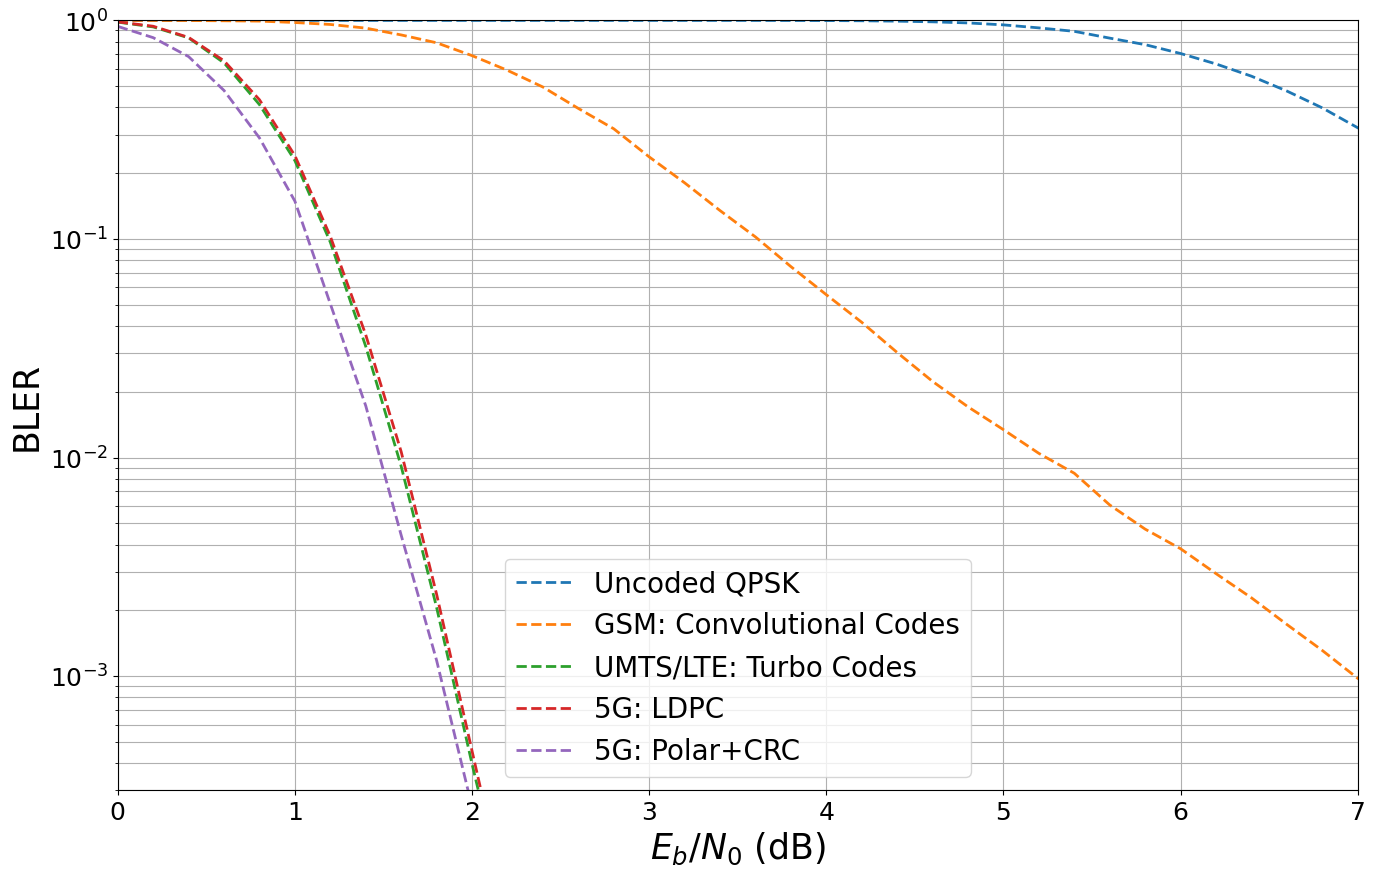

In [7]:
# remove "(BLER)" labels from legend
for idx, l in enumerate(ber_plot.legend):
    ber_plot.legend[idx] = l.replace(" (BLER)", "")
    
# and plot the BLER
ber_plot(xlim=[0, 7], ylim=[3.e-4, 1], show_ber=False)

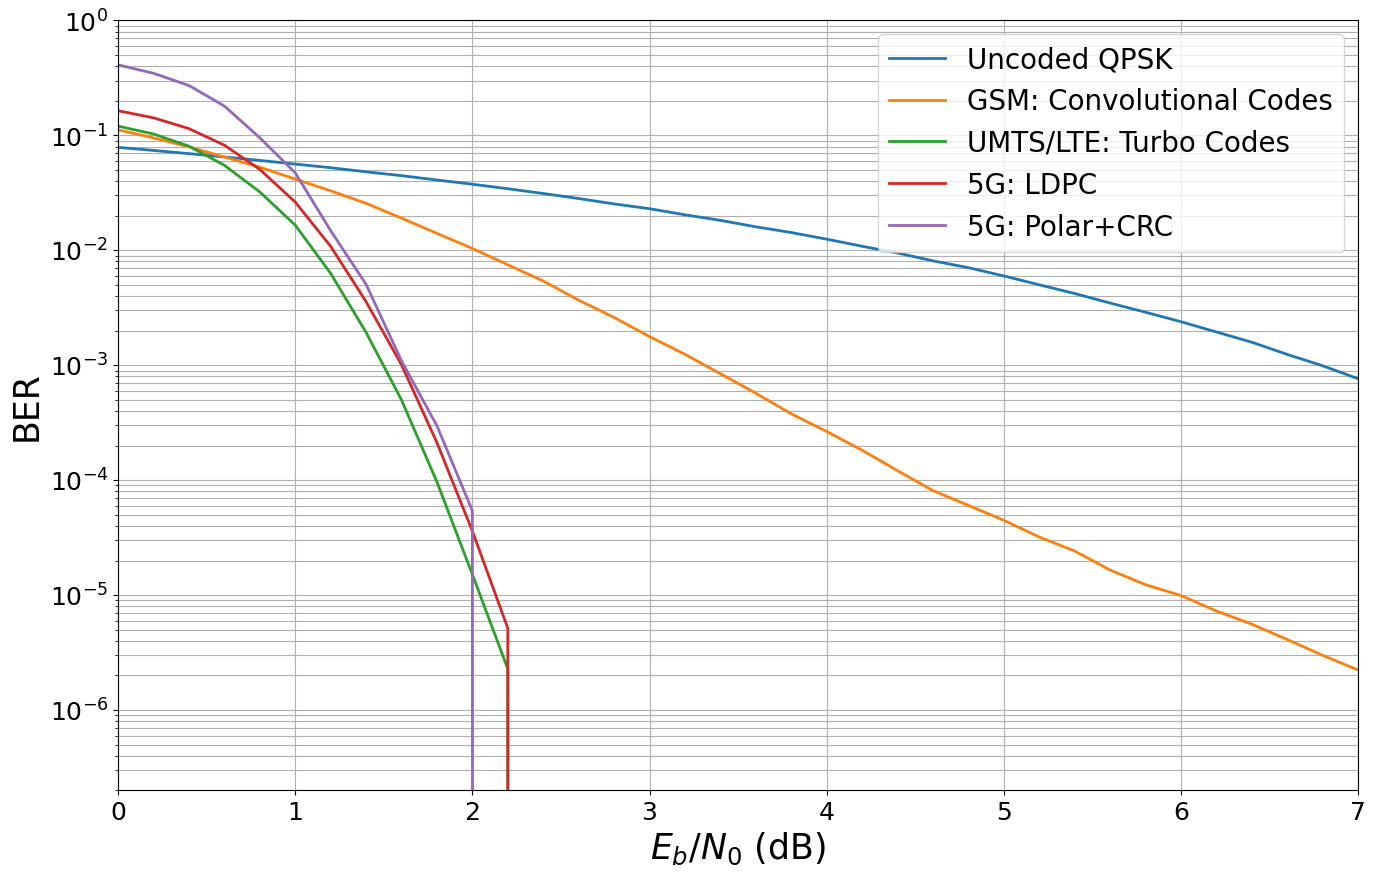

In [8]:
# BER
ber_plot(xlim=[0, 7], ylim=[2.e-7, 1], show_bler=False)

## Results for Longer Codewords

In particular for the data channels, longer codewords are usually required.
For these applications, LDPC and Turbo codes are the workhorse of 5G and LTE, respectively. 

Let's compare LDPC and Turbo codes for $k=6144$ information bits and coderate $r=1/3$.

In [9]:
# code parameters
k = 2048 # number of information bits per codeword
n = 6156 # desired codeword length (including termination bits)
codes_under_test = []

# Uncoded QPSK
enc = None
dec = None
name = "Uncoded QPSK"
codes_under_test.append([enc, dec, name])

#Turbo. codes
enc = TurboEncoder(rate=1/3, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=8)
name = "UMTS/LTE: Turbo Codes"
codes_under_test.append([enc, dec, name])

# LDPC
enc = LDPC5GEncoder(k, n)
dec = LDPC5GDecoder(encoder=enc, num_iter=40)
name = "5G: LDPC"
codes_under_test.append([enc, dec, name])

In [10]:
ber_plot_long = PlotBER(f"Error Rate Performance (k={k}, n={n})")

In [11]:
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(-1, 1.8, 0.1) # sim SNR range 

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot_long.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=1000, # run 100 Monte Carlo runs per SNR point
                     num_target_block_errors=500, # continue with next SNR point after 2000 bit errors
                     target_ber=6e-7,
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interesting
                     forward_keyboard_interrupt=False); # should be True in a loop


 Running: Uncoded QPSK
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -1.0 | 1.0363e-01 | 1.0000e+00 |     2122436 |    20480000 |        10000 |       10000 |         0.6 |reached target block errors
     -0.9 | 1.0124e-01 | 1.0000e+00 |     2073391 |    20480000 |        10000 |       10000 |         0.0 |reached target block errors
     -0.8 | 9.8453e-02 | 1.0000e+00 |     2016326 |    20480000 |        10000 |       10000 |         0.0 |reached target block errors
     -0.7 | 9.5972e-02 | 1.0000e+00 |     1965499 |    20480000 |        10000 |       10000 |         0.0 |reached target block errors
     -0.6 | 9.3551e-02 | 1.0000e+00 |     1915924 |    20480000 |        10000 |       10000 |         0.0 |reached target block errors
     -0.5 | 9.1005e-02 | 1.0000e+00 |    

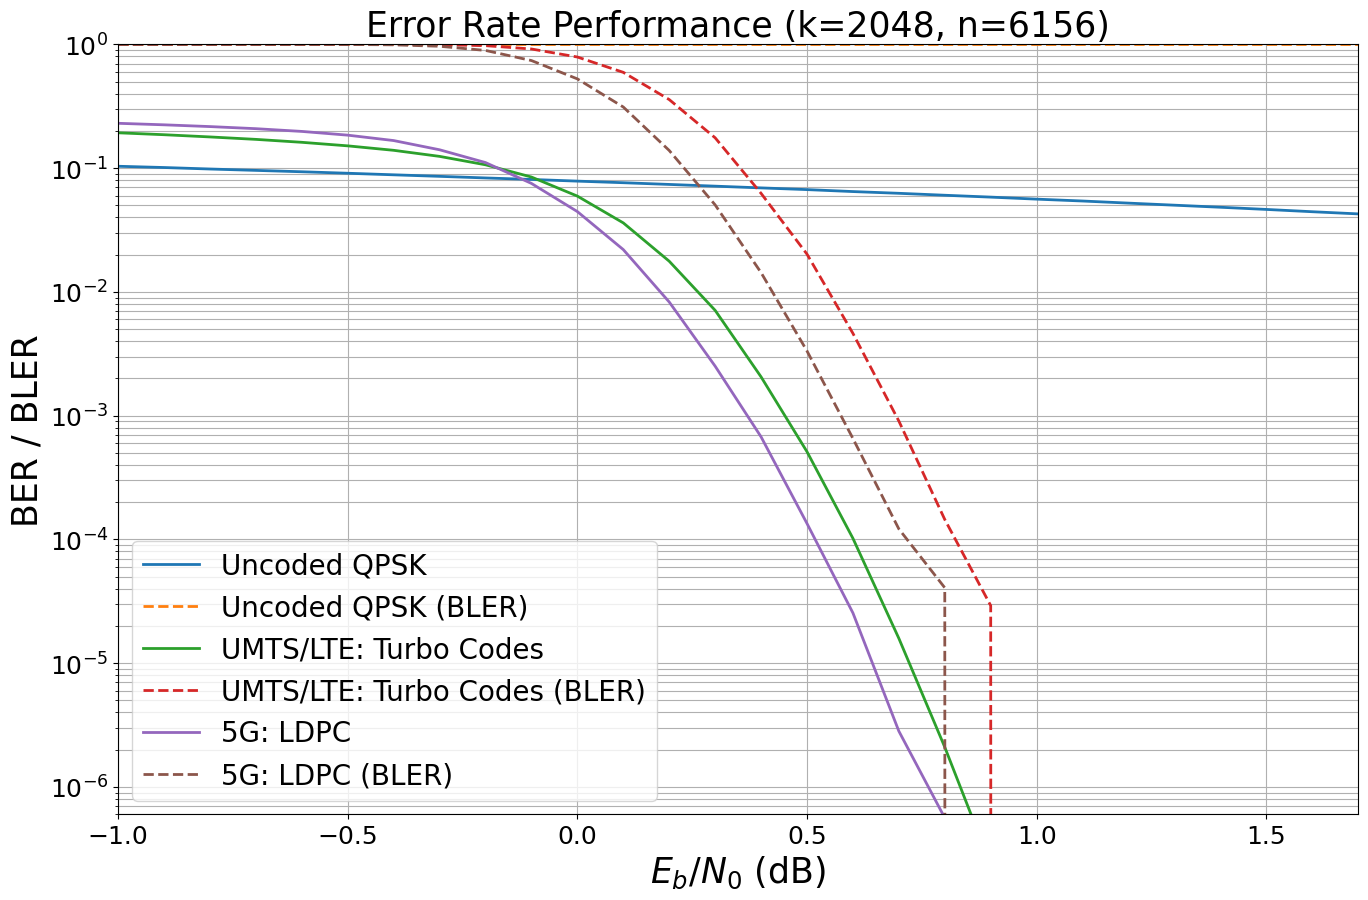

In [12]:
# and show the figure
ber_plot_long(xlim=[-1., 1.7],ylim=(6e-7, 1)) # we set the ylim to 1e-5 as otherwise more extensive simualtions would be required for accurate curves.

A comparison of short length codes can be found in the tutorial notebook [5G Channel Coding Polar vs. LDPC Codes](5G_Channel_Coding_Polar_vs_LDPC_Codes.ipynb).

## Final Figure

Combine results from the two simulations.

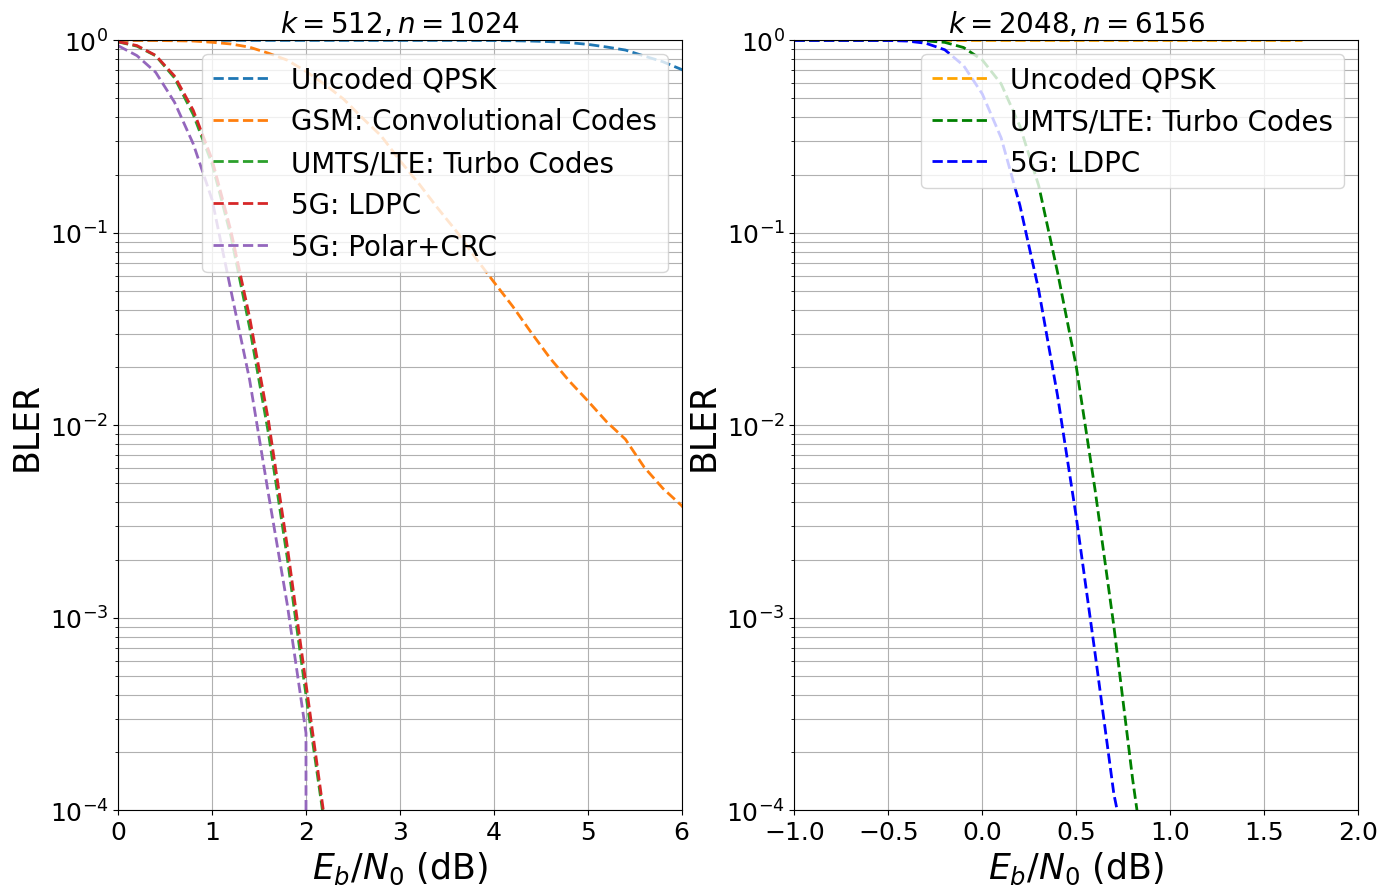

In [13]:
snrs = list(np.compress(a=ber_plot._snrs, condition=ber_plot._is_bler, axis=0))
bers = list(np.compress(a=ber_plot._bers, condition=ber_plot._is_bler, axis=0))
legends = list(np.compress(a=ber_plot._legends, condition=ber_plot._is_bler, axis=0))
is_bler = list(np.compress(a=ber_plot._is_bler, condition=ber_plot._is_bler, axis=0))

ylabel = "BLER"

# generate two subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

   
# Part A 
xlim=[0, 6]
ylim=[1e-4, 1]

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

for idx, b in enumerate(bers):
    ax1.semilogy(snrs[idx], b, "--", linewidth=2)

ax1.grid(which="both")
ax1.set_xlabel(r"$E_b/N_0$ (dB)", fontsize=25)
ax1.set_ylabel(ylabel, fontsize=25)
ax1.legend(legends, fontsize=20, loc="upper right");
ax1.set_title("$k=512, n=1024$", fontsize=20)


# remove "(BLER)" labels from legend
for idx, l in enumerate(ber_plot_long.legend):
    ber_plot_long.legend[idx] = l.replace(" (BLER)", "")
    
snrs = list(np.compress(condition=ber_plot_long._is_bler, a=ber_plot_long._snrs, axis=0))
bers = list(np.compress(condition=ber_plot_long._is_bler, a=ber_plot_long._bers, axis=0))
legends = list(np.compress(condition=ber_plot_long._is_bler, a=ber_plot_long._legends, axis=0))
is_bler = list(np.compress(condition=ber_plot_long._is_bler, a=ber_plot_long._is_bler, axis=0))


# Part B
xlim=[-1, 2]
ylim=[1e-4, 1]

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_title("$k=2048, n=6156$", fontsize=20)

# return figure handle
#for idx, b in enumerate(bers):

ax2.semilogy(snrs[0], bers[0], "--", linewidth=2, color="orange")
ax2.semilogy(snrs[1], bers[1], "--", linewidth=2, color="green")
ax2.semilogy(snrs[2], bers[2], "--", linewidth=2, color="blue")

ax2.grid(which="both")
ax2.set_xlabel(r"$E_b/N_0$ (dB)", fontsize=25)
ax2.set_ylabel(ylabel, fontsize=25)
plt.legend(legends, fontsize=20, loc="upper right");